In [1]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
#from descartes import PolygonPatch
from shapely.geometry import shape
from rasterio.plot import show
from datetime import datetime
from zipfile import ZipFile
#import geodaisy.converters as convert
import matplotlib.pyplot as plt
import rasterio.mask as mask
#import sen2mosaic.mosaic
import geopandas as gpd
import rasterio as rio
import numpy as np
import collections
import zipfile
import snappy
#import arcpy
import json
import gdal
import os

import shapely.wkt
import shapely.geometry


In [2]:
os.getcwd()
os.chdir('Documents/GitHub/sylvera/')

In [69]:
class sen2ndvi:
    def __init__(self, username, password, date, shape):
        self.date=date
        self.shape=shape
        self.username=username
        self.password=password
        
        #poly=sen2ndvi.rectpoly(self.shape)
        #Not a good programming practice, but added there to facilitate other activities.
        
        api=sen2ndvi.sen2connect(self.username, self.password)
        
        uuids, products=sen2ndvi.dynamicsearch(api, self.date, self.shape, "Level-2A")
        
        sen2ndvi.download(api, uuids, path=os.getcwd())
        
        bands=['B04','B08','TCI']
        
        allimages=[]
        
        for uuid in uuids:
            for band in bands:
                product=products[uuid]['title']
                sen2ndvi.extractband(product+'.zip', band)
                sen2ndvi.convertband(product, band)
                raster, transform=sen2ndvi.readandcropband(product, band, poly)
                sen2ndvi.exportraster(product+'_'+band+'.tif',raster, transform)
                allimages.append((raster,transform))
                
        ndviraster=sen2ndvi.ndvi(allimages[0][0], allimages[1][0])
        
        sen2ndvi.exportraster(product+'ndvi.tif',ndviraster, transform)
        
        sen2ndvi.plotexportraster(ndviraster, transform, product)
        
    def rectpoly(coord):
        # Description:
        # Takes 2 rectangular coordinates (top-left, bottom right) in the form of a 2D List: [[x1,y1], [x2,y2]]
        # and returns a geojson polygon as dict
        
        poly={'type': 'Polygon',
          'coordinates': [
            [[coord[0][0],coord[0][1]], 
             [coord[1][0],coord[0][1]], 
             [coord[1][0],coord[1][1]], 
             [coord[0][0],coord[1][1]],
             [coord[0][0],coord[0][1]]
            ]
        ]}
        return(poly)
        
    def sen2connect(username, password):
        # Description:
        # Takes a scihun username and passowrd, and returns a Sentinel 2 API connection/object where
        # where search activities can be done
        #
        # Arguments:
        #   username: your scihub username
        #   password: your scihub password
        #
        # Returns:
        #   - SentinelAPI connection object
        #
        #ToDo and/or improvements:
        #Can be updated to use files( .netrc file) instead of explicitly using username/password
        
        api=SentinelAPI(username, password)
        return(api)
    
    def staticsearch(api, date, shape, levelfilter, maxsnowcoverage='100'):
        # Desription:
        # Mehtod to search for Sentinel 2 images for a set criteria.
        # NOTE: the date range will be the between the date provide and 5 days ago. Rational is the Sentinel
        # reveisit frequency is 5 days.
        #
        # Arguments:
        #   api: a SentinelAPI connection/object (check sen2connect or SentinelAPI)
        #   date: date in the following format: yyyy-mm-dd
        #   shape: a geojson dict describing the polygon for an Area of Interest (in WGS84 crs)
        #   levelfilter: set either "Level-2A" or "Level-1C", further explanation: https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a
        #   maxsnowcoverage: set the percentage of max cloud coverage, as a str from 0 to 100. Default is 10%
        #
        # Returns:
        #  a tuple of:
        #    LIST of UUIDS
        #    OrderedDict of matching Products
        #
        # TODO and improvements:
        # look into extending to use a date range instead of 1 date
        # handle if crs is not WGS84
        # handle when products aren't returned
        # check if no products returned, if not, say no images found for this criteria
        
        
        date=date+'T23:59:59.999Z'  # Setting date formate to be date/time (as required by Scihub)
        footprint=geojson_to_wkt(shape) #Convert geojson dict to Well-Known-Text of area of interest (footprint)

        # Search for the given criteria, products is OrderedDict with image/product UUIDs as keys
        products=api.query(footprint, 
                           date = (date+'-1DAYS', date), 
                           platformname = 'Sentinel-2', 
                           cloudcoverpercentage = '[0 TO '+ maxsnowcoverage +']', 
                           processinglevel = levelfilter)

        # Extract UUID for matching products
        uuids=[]
        for uuid in products.keys():
            uuids.append(uuid)
        
        #Return a tuple of UUIDs List and an OrderedDict of Product info
        return(uuids, products)
    
    
    def dynamicsearch(api, date, shape, levelfilter, maxsnowcoverage='20', maxsearchperiod=365):
        # Description:
        # Same as staticsearch (check for more explanation), the only difference is that if search returns 
        # nothing, the search period will be extended by 5 days each time (in this case revisit frequency of 
        # Sentinel 2) until products are found, or until a max search period is reached. Set for 365 days 
        # as a default.
               
        date=date+'T23:59:59.999Z'
        footprint=geojson_to_wkt(shape)
        
        numberof=5 #Increment of days, currently set to 5 (days) to match Sentinel's revisit frequncy
        products=collections.OrderedDict() #Create empty OrderdDict to facilitate first While loop check

        while True:
            # Run until max period is reached or a result/products are returned
            if numberof>maxsearchperiod:
                return(print("No products found for current search criteria, spanning {} days from start date".format(maxsearchperiod)))
            elif bool(products):
                uuids=[]
                for uuid in products.keys():
                    uuids.append(uuid)

                return(uuids, products)
            
            # Search products as per criteria
            products=api.query(footprint, 
                               date = (date+'-'+str(numberof)+'DAYS', date), 
                               platformname = 'Sentinel-2', 
                               cloudcoverpercentage = '[0 TO '+ str(maxsnowcoverage) +']', 
                               processinglevel = levelfilter)
            
            # Increment search period by 5 days if no products returned
            if not bool(products):
                # Used for debugging to check the range of days we're searching for at the moment
                # but found it useful so I left the print statement
                print("Extending search for the last {} days from start date".format(numberof), end="\r")
                numberof=numberof+5

    
    def download(api, uuids, path='.'):
        # Description:
        # Download images/products using their UUID
        #
        # Arguments:
        #   api: scihub connection/object as per sen2connect or SentinelAPI
        #   uuids: list of uuids to download, e.g: ['2badfc11-7f0a-4225-bc73-14504d2872fc', 'fe48a72b-0ad2-46e7-b628-42465267dc99']
        #   path: directory to where to download files, set to working directory as a default
        #
        # ToDos and Improvements:
        # Confirm directory exists (use assert?)
        for uuid in uuids:
            api.download(uuid, directory_path=path)
            
    def extractband (zipname, band):
        # Description:
        # For a given zipped sentinel 2 image, this function will extract only the band provided
        #
        # Arguments:
        #   zipname: directory/zipname with extention (.zip)
        #   band: a 3 letter string of the band to extract: "B01", "B02"....."B12" or "TCI"
        #
        # ToDos and Improvements:
        # check filename exists
        # make sure band name is valid
        # Use REGEX to check for bands instead of hard coding in case naming convention changes
        
        with ZipFile(zipname, 'r') as zipObj:
                listOfFileNames = zipObj.namelist() #Get list of files/directories in zip
                for fileName in listOfFileNames:    #Loop each file/direcotry
                    if fileName.endswith(band+'_10m.jp2') or fileName.endswith(band+'.jp2'): #check if name contains band name, I encountered 2 formats (pre 2018 images don't have resoltuion as part of filename, that's why I had the OR)
                        with open(zipname[:-4]+'_'+band+'.jp2', 'wb') as f: #Open band, need to replace with regex to be neater and future proof
                            f.write(zipObj.read(fileName)) #unzip and write out jp2 file
                            
    def jp2tif_wgs84 (path, dsn):
        # Description:
        # Converts JP2 to tiff (a more common format), and converts CRS to WGS84
        # 
        # Arguments:
        #   path: directory of jp2
        #   dsn: destination of output tiff
        #
        # ToDos & Improvemnts:
        # Check if file exists (assert?)
        
        #Open JP2 image with GDAL
        jp2=gdal.Open(path)

        #Convert JP2 to Tiff AND convert CRS to WGS84 (epsg number: 4326) using gdal.warp
        gdal.Warp(dsn, jp2, dstSRS='EPSG:4326')
        
    #------------------------------------------------------------------------
    #The following two methods have just been added there for experimentation
    #Will tidy up once a conclusion is made
    def convertformatonly (filename, band):
        jp2=gdal.Open(filename + '_' + band + '.jp2')
        
        gdal.Warp(filename + '_' + band + '.tif', jp2)
    
    def convertcrs (filename):
        original=gdal.Open(filename)
        
        gdal.Warp(filename, original, dstSRS='EPSG:4326')
    #------------------------------------------------------------------------    
   
    def convertband (filename, band):
        # Description:
        # Same as jp2tiff_wgs84, but takes a band and a title for sentinel 2 image, it was done to use in a for
        # loop, that goes through bands. It was created since it was easier working with UUIDs and Sen 2 Products
        #
        # Arguments:
        #   filename: name of sentinel 2 file (i.e zip file sans ".zip")
        #   band: a 3 letter string of the band: "B01", "B02"....."B12" or "TCI"
        #
        # ToDos Improvements:
        # check filename exists
        # make sure band name is valid
        sen2ndvi.jp2tif_wgs84(filename + '_' + band + '.jp2', filename + '_' + band + '.tif')

    def readandcrop (path, poly):
        # Description:
        # Read tif and acquire/crop required potion only
        #
        # Arguments:
        #   path: directory of tif file
        #   poly: a geojson dict, the "geometry node" only, e.g:
        #     {'type': 'Polygon',
        #      'coordinates': [[[long1, lat1],
        #                       [long2, lat2],.....
        #
        #                       [long1, lat1]]]
        #     }
        #
        # Returns:
        #   - Cropped raster
        #   - Transform/affine of cropped raster
        #
        # ToDos & Improvements:
        #  Check file exists
        #  Check poly is in required format
        
        #Open file with Tiff file using rasterio
        with rio.open(path) as src:

            #Read cropped area of tiff based on Polygon, which returns a raster and an affine/transform
            #Transforms are handy when plotting raster and exporting files to set extent of raster
            raster_image, raster_transform = mask.mask(dataset=src,shapes=[poly],crop=True)

        #Return cropped image and its transform
        return raster_image, raster_transform
    
    def readandcropband(filename, band, poly):
        # Description:
        # Same as readandcrop, except that it requires a specific band to be returned, this was done to faciliate
        # for loops when going through different bands. The other difference is that the filename is the title of
        # sentinel 2 images (sans the file extension)
        #
        # ToDos & Improvements:
        # check filename exists
        # make sure band name is valid
        # Delete files after crop? Since original files are huge
        return(sen2ndvi.readandcrop(filename + '_' + band + '.tif', poly))
    

    def exportraster(dsn, raster, transform):
        # Description:
        # Function to export rasters as GeoTiffs
        #
        # Arguments:
        #   dsn: output destination (including extenion)
        #   raster: raster to write out, as per rasterio (or a masked numpy array)
        #   transform: tranform/affine object (affine.Affine) which sets extent of the image
        #    e.g: Affine(9.004196142920968e-05, 0.0, 17.69517668168249,0.0, -9.004196142920968e-05, -1.584559077958359)
        #
        # ToDos & Improvemnts:
        # check dsn exists/valid
        
        
        output=rio.open(dsn,                    #Destination path
                        'w',                    #Write mode
                        driver='GTiff',         #Set driver/output formate: GeoTiff
                        height=raster.shape[1], #Get height of raster and set height for output file
                        width=raster.shape[2],  #Get width of raster and set width for output file
                        count=raster.shape[0],  #Get how many bands, for e.g True Color has 3: RGB, and set for count
                        dtype=raster.dtype,     #Get and set datatype of tif
                        transform=transform)    #Set transform
        output.write(raster)
        output.close()

    def ndvi(red, nir):
        # Description:
        # A function that takes 2 rasters/numpy arrays (Infrared and Near Infrared) and calculates NDVI
        # 
        # Arguments:
        #   ir : a raster/numpy maksed array if Infrared image (Band 4 in Sentinel 2)
        #   nir: a raster/numpy maksed array if Near Infrared image (Band 8 in Sentinel 2)
        # Returns:
        #   - NDVI raster/masked numpy array
        
        # Apply: NDVI=(NIR-IR)/(NIR+IR)
        # Force numbers into float, since rasterio uses unsigned int, which produces bizzare outputs when there
        # are negative values
        ndviraster=(nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float))
        
        # Sanity check result if it lies between 1 and -1, if not print warning
        if np.nanmax(ndviraster)>1 or np.nanmin(ndviraster)<-1:
            print("There are values outside the range of 1 and -1, check file. The raster is still generated")
        
        return(ndviraster)
    
    def plotexportraster(raster, transform, dsn):
        # Description:
        # Function to plot raster and export plot as a png. It was done as a stop-gap, since export of NDVI rasters,
        # which have 1 layer tif, can't be viewed as a normal image in the OS (which requires RGB). Need to confirm
        # that assumption.
        #
        # Arguments:
        #   raster: a rasterio raster/numpy masked array
        #   transform: a transform to set extent of plot, check exportraster for more info
        #   dsn: destination of output file with file extention to be included
        #
        
        #aspectratio=raster.shape[2]/raster.shape[1] # Get aspect ratio
        fig, ax=plt.subplots();#figsize=(aspectratio*3.75,3.75)); # this was done with trial and error and that step can be foresaken, as it's only true for certain size
        show(raster,
             ax=ax,
             cmap='RdYlGn', #colour scheme Red, Yellow, Green  
             vmin=-1,
             vmax=1,
             transform=transform);
        plt.axis('off')
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()) #Set extent of plot
        plt.savefig(dsn, bbox_inches=extent) #save plot as png
        
    def diffndvi(before,after):
        # Description:
        # Function to calcualte and normalise difference of two NDVIs (only works for NDVI due to normalisation parameter)
        #
        # Arguments:
        #   before: raster/numpy masked array
        #   after: raster/numpy masked array
        #
        # Calculate difference and normalise (divide by 2 because the range is 2 (-1 to 1))
        return((after-before)/2)
    
    def mosaic(outputfile, filenames):
        # Descritpion:
        # Function to stitch together different tifs using GDAL
        #
        # Arguments:
        #   outputfile: path of output file
        #   filenames: a LIST of tif paths, e.g: ['image1.tif','image2.tif'....]
        #
        # Create a string for the input tifs using a for loop
        rasters=''
        for file in filenames:
            rasters=rasters+file+" "
        
        # Create the GDAL Terminal command, note: files is initialised to black(255) to fill empty areas
        gdalscript='gdal_merge.py -init 255 -o '+outputfile+' '+rasters
        
        #run terminal command, I didn't face any sudo issues, but not sure if others will using this.
        os.system(gdalscript)

Below is an example calling the ```sen2ndvi``` class. By providing a:

- Scihub username and passwrod
- date of interest
- a polygon describing area of interest

The method will:

- Search for Sentinel 2 image for Area of Interest (AOI) and that specific date
- Download images matching the above criteria
- Convert Bands 4 & 8 to CRS WGS84
- Crop Band 4 and 8 according to AOI
- Calculate NDVI
- Plot NDVI of AOI
- Export NDVI as tif and png

/Users/omarnooreddin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:300: RuntimeWarning: divide by zero encountered in true_divide
/Users/omarnooreddin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:300: RuntimeWarning: invalid value encountered in true_divide


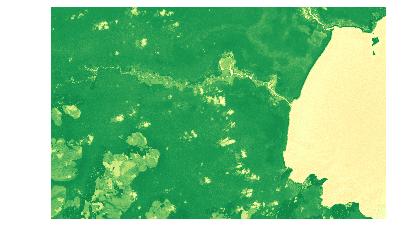

In [33]:
#Example
#Create geojson from rectangular coordinates
poly=sen2ndvi.rectpoly([[17.834244,-1.603108],[18.119202,-1.783617]])

#Search, download, unzip, crop, calculate NDVI, export NDVI (tif+png) and plot:
sen2ndvi('username', 'password','2020-04-08',poly)

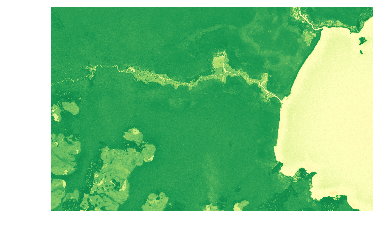

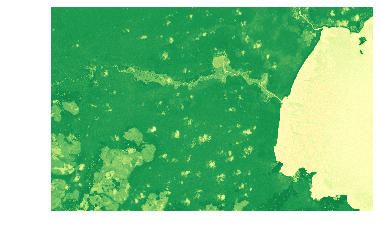

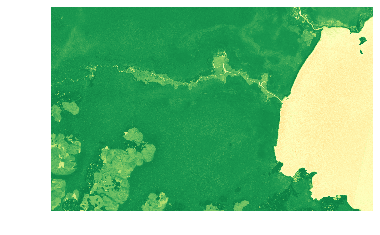

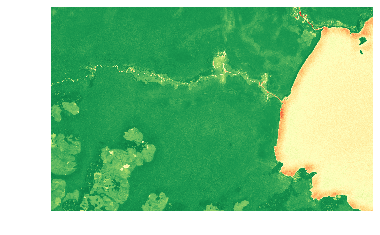

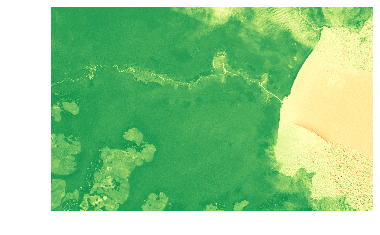

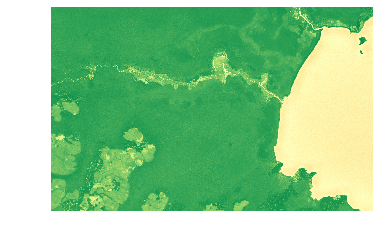

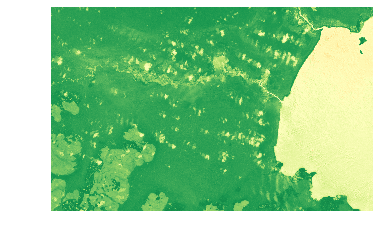

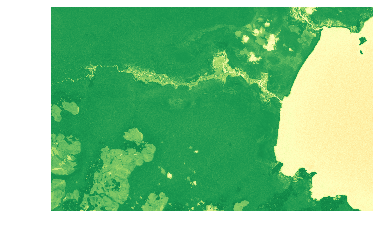

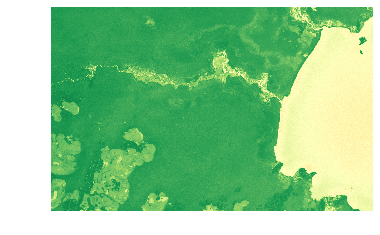

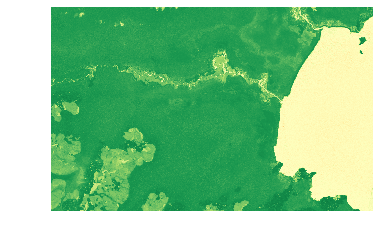

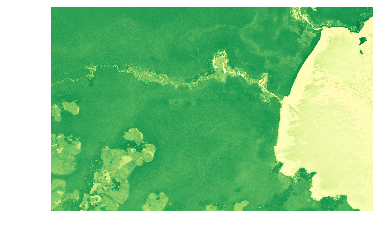

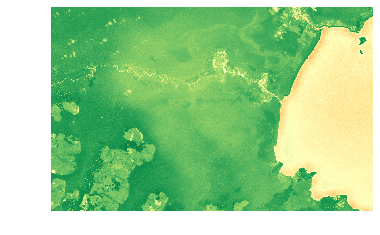

In [301]:
#Mai Ndombe REDD++

# monthly from Mar 2019 to May 2020, where there was no (or minimal) cloud coverage of Mai Ndombe subsection
dates=['2019-03-09','2019-04-03','2019-05-08', '2019-06-07','2019-07-17','2019-08-06','2019-10-25','2020-01-13','2020-02-02','2020-03-28','2020-04-02','2020-05-17']
for date in dates:
    sen2ndvi('username', 'password',date,[[17.834244,-1.603108],[18.119202,-1.783617]])

In [ ]:
# Check if products are "Online" or archived under the LTA (Long Term Archive) program
# If an image is archived, a download request will trigger a request and the file will become "online" within 24 hrs
dates=['2016-01-29','2017-01-03', '2017-05-03','2018-01-08','2018-03-04', '2018-06-07', '2018-07-07', '2019-06-27', '2019-08-31', '2019-10-25', '2020-01-28', '2020-03-28', '2020-04-27', '2020-05-17']
uuids=[]
for date in dates:
    products=api.query(footprint, date=(date+'T23:59:59.999Z-5DAYS', date+'T23:59:59.999Z'),platformname = 'Sentinel-2')
    for uuid, body in products.items():
        if api.get_product_odata(uuid)['Online']: #That's the call to check if a product is online by providing UUID
            print(date)
            uuids.append(uuid)

2019-03-09
4


/Users/omarnooreddin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:314: RuntimeWarning: divide by zero encountered in true_divide
/Users/omarnooreddin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:314: RuntimeWarning: invalid value encountered in true_divide


2019-04-18
4
2019-05-08
4
2019-06-07
4
2019-07-17
4
2019-08-06
4
2019-10-05
4
2020-01-13
4
2020-02-07
4
2020-03-28
4
2020-04-07
4


/Users/omarnooreddin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2020-05-17
4


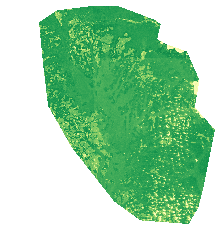

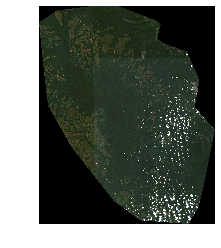

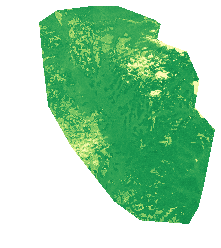

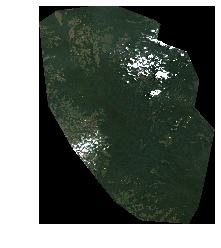

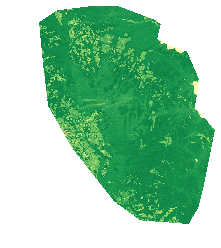

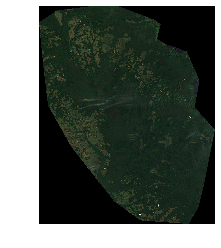

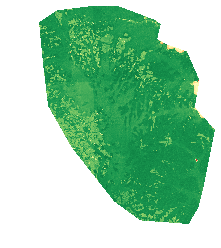

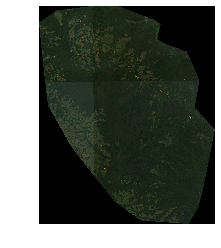

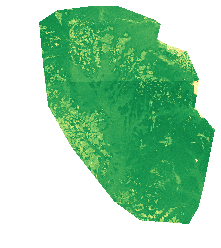

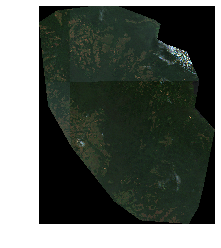

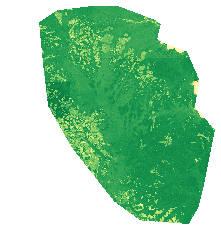

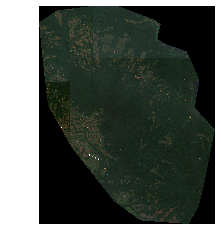

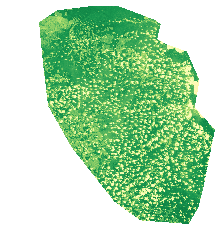

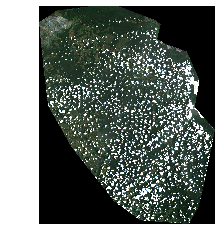

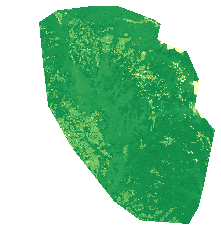

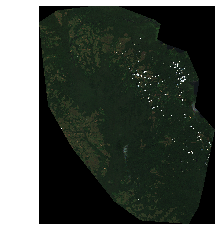

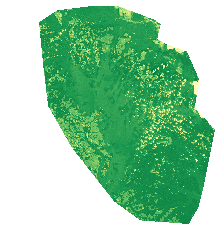

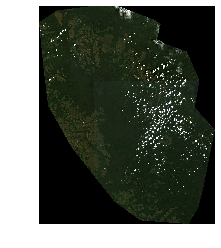

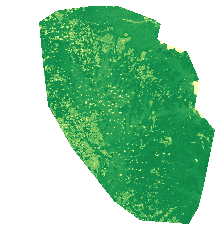

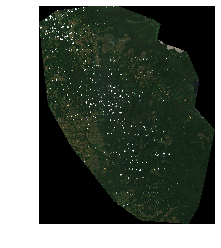

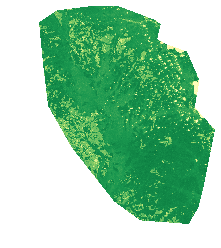

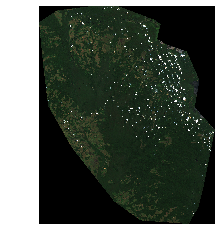

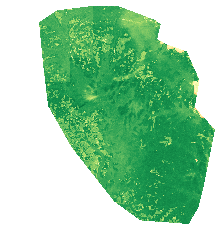

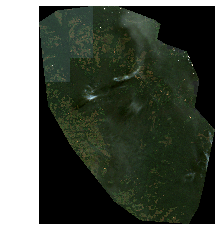

In [104]:
mainndombe_project={"type":"Polygon","coordinates":[[[17.576752,-1.669686],[17.645416,-1.624386],[17.778625,-1.607913],[17.877502,-1.607913],[18.023071,-1.662822],[18.039551,-1.677922],[18.027191,-1.732829],[18.061523,-1.753419],[18.139801,-1.780872],[18.187866,-1.890679],[18.170013,-1.993616],[18.246918,-2.079393],[18.201599,-2.304447],[18.184433,-2.373741],[18.146667,-2.438229],[17.962646,-2.424508],[17.86377,-2.353159],[17.701721,-2.147324],[17.611084,-1.988126],[17.591858,-1.826168],[17.576752,-1.669686]]]}

api=sen2ndvi.sen2connect('username','password')
#'2019-03-09','2019-04-18', '2019-05-08','2019-06-07','2019-07-17','2019-08-06','2019-10-05','2020-01-13','2020-02-07','2020-03-28','2020-04-07','2020-05-17'
dates=['2019-03-09','2019-04-18', '2019-05-08','2019-06-07','2019-07-17','2019-08-06','2019-10-05','2020-01-13','2020-02-07','2020-03-28','2020-04-07','2020-05-17']
bands=['B04','B08']

for date in dates:
    print(date)
    #1. Search
    uuids, product=sen2ndvi.staticsearch(api, date, mainndombe_project, "Level-2A", maxsnowcoverage='100')
    print(len(product))
    
    #2. Download
    sen2ndvi.download(api, uuids)
    
    allimages=[]

    for band in bands:
        tiles=[]
        for uuid in uuids:
            #3. unzip
            sen2ndvi.extractband(product[uuid]['title']+'.zip', band)
            #4. convert
            sen2ndvi.convertformatonly(product[uuid]['title'], band)
            
            #4.1 add tile name to list (for use in mosiac function)
            tiles.append(product[uuid]['title']+'_'+band+'.tif')
            
            
            
        #5. Stitch    
        sen2ndvi.mosaic(date+'_'+band+'_'+'ALL.tif',tiles)
        
        #6. Delete individual file bands
        for tile in tiles:
                os.system('rm '+tile)
                os.system('rm '+tile[:-3]+'jp2')
        
        #6.1 convert CRS 
        sen2ndvi.convertcrs(date+'_'+band+'_'+'ALL.tif')
            
        #7. Read and Crop
        raster, transform=sen2ndvi.readandcrop(date+'_'+band+'_'+'ALL.tif', mainndombe_project)
        
        #8. Add to LIST
        allimages.append((raster,transform))
        
    #9. Calculate NDVI
    ndvi=sen2ndvi.ndvi(allimages[0][0],allimages[1][0])
    
    #10. Export NDVI tif
    sen2ndvi.exportraster(date+'_NDVI.tif', ndvi,allimages[0][1])
    
    #11. Delete Stitched Up Band images
    for band in bands:
        os.system('rm '+date+'_'+band+'_'+'ALL.tif')

    #12. Export as PNG 
    sen2ndvi.plotexportraster(ndvi, allimages[0][1],date+'_NDVI.png')
    
    #Repeat for TCI
    tiles=[]
    for uuid in uuids:
        
        sen2ndvi.extractband(product[uuid]['title']+'.zip', 'TCI')
        
        sen2ndvi.convertformatonly(product[uuid]['title'], 'TCI')

        tiles.append(product[uuid]['title']+'_TCI'+'.tif')
                
    sen2ndvi.mosaic(date+'_TCI_ALL.tif',tiles)
    for tile in tiles:
                os.system('rm '+tile)
                os.system('rm '+tile[:-3]+'jp2')
                
    sen2ndvi.convertcrs(date+'_TCI_ALL.tif')
    
    raster, transform=sen2ndvi.readandcrop(date+'_TCI_ALL.tif', mainndombe_project)
    
    sen2ndvi.exportraster(date+'_TCI.tif', raster,transform)
    
    sen2ndvi.plotexportraster(raster, transform, date+'_TCI.png')
    
    os.system('rm '+date+'_TCI_ALL.tif')
    

Checking for images if they're online. SciHub has a [policy](https://scihub.copernicus.eu/userguide/LongTermArchive) of what images are immediately available, and what is kept offline, and that's what defines an "online" product.

For offline products, a retrieval requests has to be invoked, which will make the image/product available within 24 hours or less.

With ```SentinelAPI``` a download request of an offline request will invoke a retrieval request.

Below is an example how to check and invoke offline products